In [1]:
# Useful libraries
import numpy as np
import scipy as sp
import random
import os
# Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [16]:
Deltat = 0.005
temperature = 0.41 #K

In [2]:
def read_lammps_dump(filename):
    positions = {}
    with open(filename, 'r') as file:
        while True:
            line = file.readline()
            if not line:
                break  # Fine del file

            if "ITEM: TIMESTEP" in line:
                timestep = int(file.readline().strip())
                file.readline()  # ITEM: NUMBER OF ATOMS
                num_atoms = int(file.readline().strip())
                file.readline()  # ITEM: BOX BOUNDS
                for _ in range(3):
                    file.readline()  # BOUNDS LINES
                
                file.readline()  # ITEM: ATOMS id type xu yu zu

                atom_data = []
                for _ in range(num_atoms):
                    atom_info = file.readline().strip().split()
                    atom_id = int(atom_info[0])
                    atom_type = int(atom_info[1])
                    x, y, z = map(float, atom_info[2:])
                    atom_data.append([atom_id, atom_type, x, y, z])
                
                positions[timestep] = np.array(atom_data)

    return positions

In [4]:
# Dictionaries (very long operation):
positionsA = read_lammps_dump('dump_A_positions_T_041.lammpstrj')
positionsB = read_lammps_dump('dump_B_positions_T_041.lammpstrj')

# Check:
for timestep in sorted(positionsA.keys()):
    print(f"Timestep: {timestep}, Shape: {positionsA[timestep].shape}")
    print(f"Timestep: {timestep}, Shape: {positionsB[timestep].shape}")
    break  # only first timestep (timestep: 0)

Timestep: 1, Shape: (800, 5)
Timestep: 1, Shape: (200, 5)


In [5]:
# Constructing the positions array
# We can create a positions array by organizing the x, y, z coordinates of the particles for each timestep:
def prepare_positions_for_Q(dump_data):
    """
    Parameters:
        dump_data (dict): Position data from LAMMPS dump in dictionary form.
                          The key is the timestep and the value is a numpy array (n_particles, 5)
                        where 5 are: (atom_id, x, y, z, ...)
                          
    Returns:
        positions (np.array): positions array with shape: (n_steps, n_particles, 3)
    """
    timesteps = sorted(dump_data.keys())  # Sorting array for time step
    n_steps = len(timesteps)
    n_particles = dump_data[timesteps[0]].shape[0]
    
    positions = np.zeros((n_steps, n_particles, 3))
    
    for i, t in enumerate(timesteps):
        positions[i] = dump_data[t][:, 1:4]  # extracts columns x, y, z
    
    return positions

In [7]:
# Positions for A and B:
positions_A_lammps = prepare_positions_for_Q(positionsA)
positions_B_lammps = prepare_positions_for_Q(positionsB)

# Array numpy for positions:
positions_lammps = np.concatenate((positions_A_lammps, positions_B_lammps), axis=1)

In [11]:
# Function that determines the MSD for the particles
def calculate_msd(positions):
    num_timesteps = positions.shape[0]
    num_atoms = positions.shape[1]
    msd = np.zeros(num_timesteps)
    
    for t in range(num_timesteps):
        displacement = positions[t] - positions[0]
        squared_displacement = np.sum(displacement ** 2, axis=1)
        msd[t] = np.mean(squared_displacement)
    
    return msd

In [12]:
# MSD calculation for both atoms groups
msd_A = calculate_msd(positions_A_lammps)
msd_B = calculate_msd(positions_B_lammps)

msd   = calculate_msd(positions_lammps)

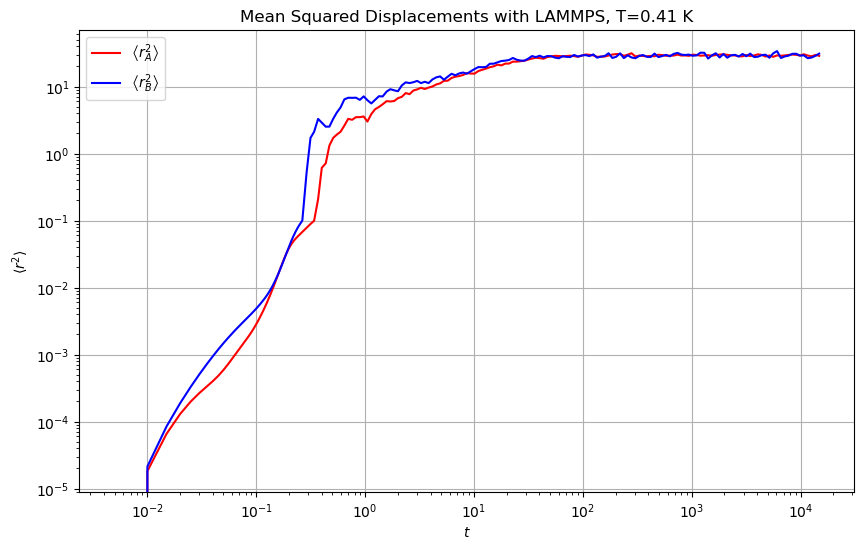

In [23]:
# Logarithmic Timesteps taken from the dictionary keys
timesteps = sorted(positionsA.keys())  

# Unidimensional time array:
t = np.array(timesteps) * Deltat

# Plot of msd:
plt.figure(figsize=(10, 6))
plt.loglog(t, msd_A, label=r'$\left\langle r_{A}^2 \right\rangle$', color='red')
plt.loglog(t, msd_B, label=r'$\left\langle r_{B}^2 \right\rangle$', color='blue')
plt.xlabel('$t$')
plt.ylabel(r'$\left\langle r^2 \right\rangle$')
plt.title(f'Mean Squared Displacements with LAMMPS, T={temperature} K')
plt.legend()

plt.grid(True)
plt.show()

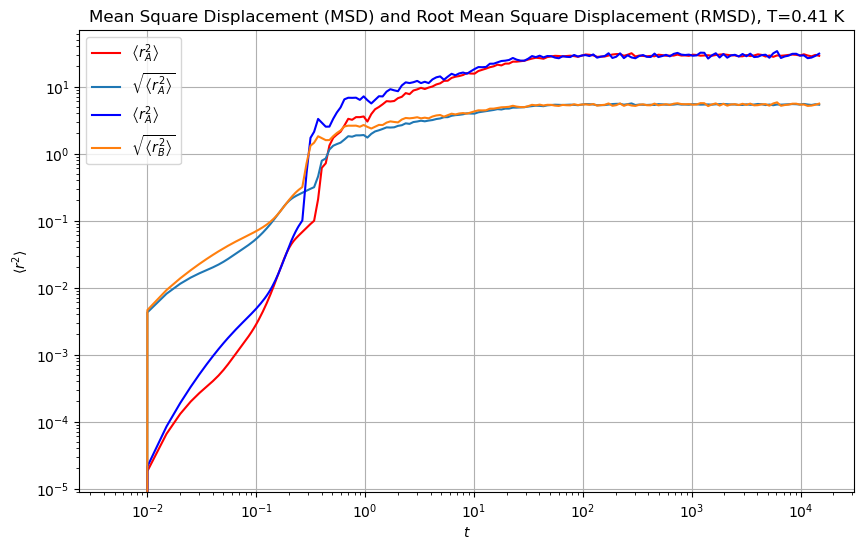

In [26]:
# Calcolo RMSD
rmsd_A = np.sqrt(msd_A)
rmsd_B = np.sqrt(msd_B)

# Plotting MSD e RMSD
plt.figure(figsize=(10, 6))
plt.loglog(t, msd_A, label=r'$\left\langle r_{A}^2 \right\rangle$', color='red')
plt.loglog(t, rmsd_A, label=r'$\sqrt{\left\langle r_{A}^2 \right\rangle}$')
plt.loglog(t, msd_B, label=r'$\left\langle r_{A}^2 \right\rangle$', color='blue')
plt.loglog(t, rmsd_B, label=r'$\sqrt{\left\langle r_{B}^2 \right\rangle}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle r^2 \right\rangle$')
plt.legend()
plt.grid(True)
plt.title(f'Mean Square Displacement (MSD) and Root Mean Square Displacement (RMSD), T={temperature} K')
plt.show()

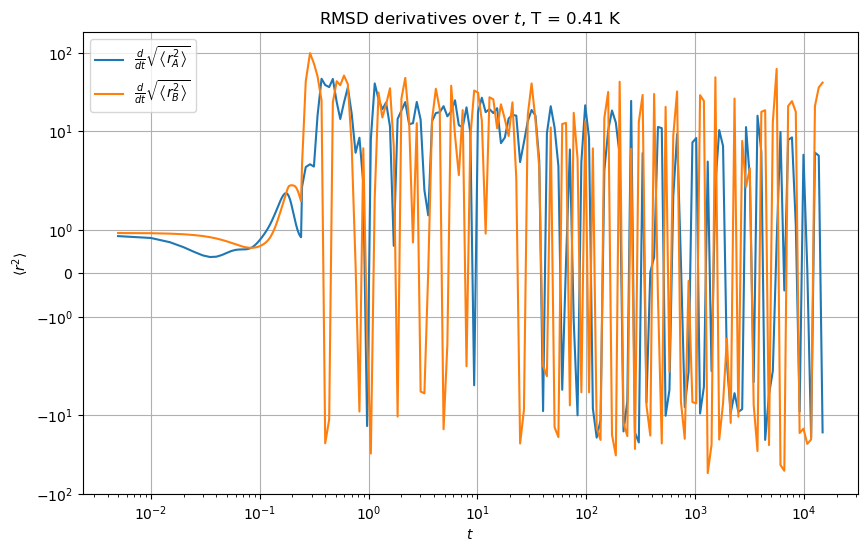

In [29]:
def calculate_derivatives(rmsd_A, rmsd_B, Deltat):
    # Unidimensional array representing time with the same length as rmsd arrays
    time = np.arange(len(rmsd_A)) * Deltat
    
    # Calculation of the RMSD derivative for both types of atoms
    # Numerical derivative of the rmsd over time:
    rmsd_A_derivative = np.gradient(rmsd_A, time)
    rmsd_B_derivative = np.gradient(rmsd_B, time)
    
    return rmsd_A_derivative, rmsd_B_derivative

rmsd_A_derivative, rmsd_B_derivative = calculate_derivatives(rmsd_A, rmsd_B, Deltat)

# Plotting RMSD derivatives:
plt.figure(figsize=(10, 6))
plt.loglog(t, rmsd_A_derivative, label=r'$\frac{d}{dt}\sqrt{\left\langle r_{A}^2 \right\rangle}$')
plt.loglog(t, rmsd_B_derivative, label=r'$\frac{d}{dt}\sqrt{\left\langle r_{B}^2 \right\rangle}$')

    
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle r^2 \right\rangle$')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise
plt.legend()
plt.title(f'RMSD derivatives over $t$, T = {temperature} K')
plt.grid(True)
plt.show()

In [24]:
def find_a0(rmsd_A, rmsd_B, Deltat, threshold):
    """
    Parameters:
        rmsd_A (np.array): RMSD for A type of atoms.
        rmsd_B (np.array): RMSD for B type of atoms.
        Deltat (float): Time interval between steps.
        threshold (float): Number to find a plateau.
    
    Returns:
        a0 (float): r value corresponding to the start of the plateau.
    """
    # Unidimensional array representing time
    time = np.arange(len(rmsd_A)) * Deltat
    
    # Calculation of the RMSD derivative for both types of atoms
    # Numerical derivative of the rmsd over time:
    rmsd_A_derivative = np.gradient(rmsd_A, time)
    rmsd_B_derivative = np.gradient(rmsd_B, time)
    
    # Iteration through the derivative values to find the plateau
    for i in range(3, len(rmsd_A_derivative)):
        if (abs(rmsd_A_derivative[i] - rmsd_A_derivative[i-2]) < threshold and 
            abs(rmsd_B_derivative[i] - rmsd_B_derivative[i-2]) < threshold):
            # If derivative is sufficiently low,  return the RMSD value corresponding to the plateau
            return (rmsd_A[i] + rmsd_B[i]) / 2  # Average value of rmsd_A and rmsd_B
    
    # If no plateau has been found, return None
    return None

a_0 is approximately 0.04626108697211104


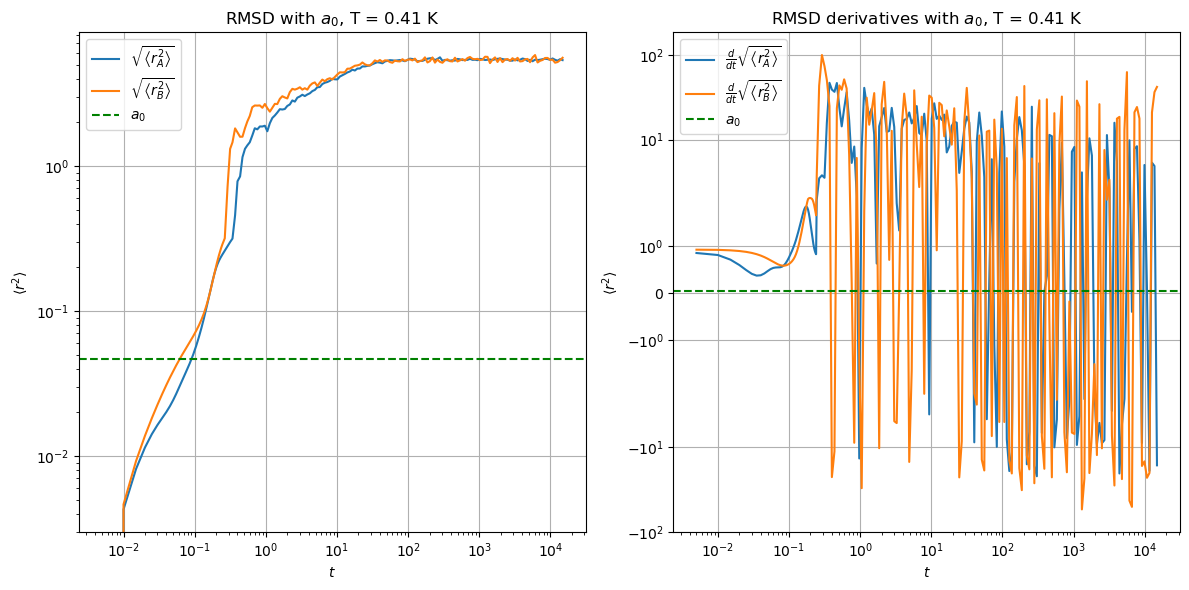

In [33]:
# Set a threshold for detecting a0:
threshold = 0.05

# Find a_0
a0 = find_a0(rmsd_A, rmsd_B, Deltat, threshold)

if a0 is not None:
    print(f"a_0 is approximately {a0}")
else:
    print("a_0 not found within the given range.")

# Results Visualization:
plt.figure(figsize=(12, 6))

# Plot per RMSD:
plt.subplot(1, 2, 1)
plt.loglog(t, rmsd_A, label=r'$\sqrt{\left\langle r_{A}^2 \right\rangle}$')
plt.loglog(t, rmsd_B, label=r'$\sqrt{\left\langle r_{B}^2 \right\rangle}$')
# Highlights a_0
if a0 is not None:
    plt.axhline(y=a0, color='green', linestyle='--', label=f'$a_0 \approx {a0: .2f}$')   
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle r^2 \right\rangle$')
plt.legend()
plt.grid(True)
plt.title(f'RMSD with $a_0$, T = {temperature} K')

# Plot per dRMSD/dt:
plt.subplot(1, 2, 2)
plt.loglog(t, rmsd_A_derivative, label=r'$\frac{d}{dt}\sqrt{\left\langle r_{A}^2 \right\rangle}$')
plt.loglog(t, rmsd_B_derivative, label=r'$\frac{d}{dt}\sqrt{\left\langle r_{B}^2 \right\rangle}$')
# Highlights a_0
if a0 is not None:
    plt.axhline(y=a0, color='green', linestyle='--', label=f'$a_0 \approx {a0: .2f}$')  
plt.xlabel(r'$t$')
plt.ylabel(r'$\left\langle r^2 \right\rangle$')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise

plt.legend()
plt.title(f'RMSD derivatives with $a_0$, T = {temperature} K')
plt.grid(True)

plt.tight_layout()
plt.show()

In [34]:
def calculate_Q(positions, a0):
    # Ricorda: 'positions' è un array Numpy con dimensioni : (n_steps, n_particles, 3)
    n_particles = positions.shape[1]  # Numero di particelle
    n_steps     = positions.shape[0]  # Numero di passi temporali
    
    Q = np.zeros(n_steps, dtype=np.float64)
    
    for t in range(n_steps):
        somma = 0  # Inizializza la somma per ogni passo temporale
        for i in range(n_particles):
            # Calcola le distanze delle particelle dalla loro posizione iniziale al tempo t
            distance = np.linalg.norm(positions[t, i] - positions[0, i])
        
            # Applica la funzione finestra: 1 se la distanza è <= a0, 0 altrimenti
            if distance <= a0:
                w = 1
            else:
                w = 0
                
            somma += w  # Aggiungi il valore di w alla somma
        
        # Q(t):
        Q[t] = somma 
    
    return Q/n_particles

In [35]:
# Detection of t_alpha for Q_total:
def find_tau_alpha(Q):
    """
    Finds tau_alpha, time step in which Q(t) decreases to 1/e
    
    Parameters:
    Q (numpy array)

    Returns:
    tau_alpha (int)
    """
    
    # Compute 1/e (Q_initial/e):
    Q_initial = Q[0]
    target_value = Q_initial / np.e
    
    # Find index in which Q(t) is nearest to Q(0)/e:
    tau_alpha_index = np.argmin(np.abs(Q - target_value))
    
    return tau_alpha_index

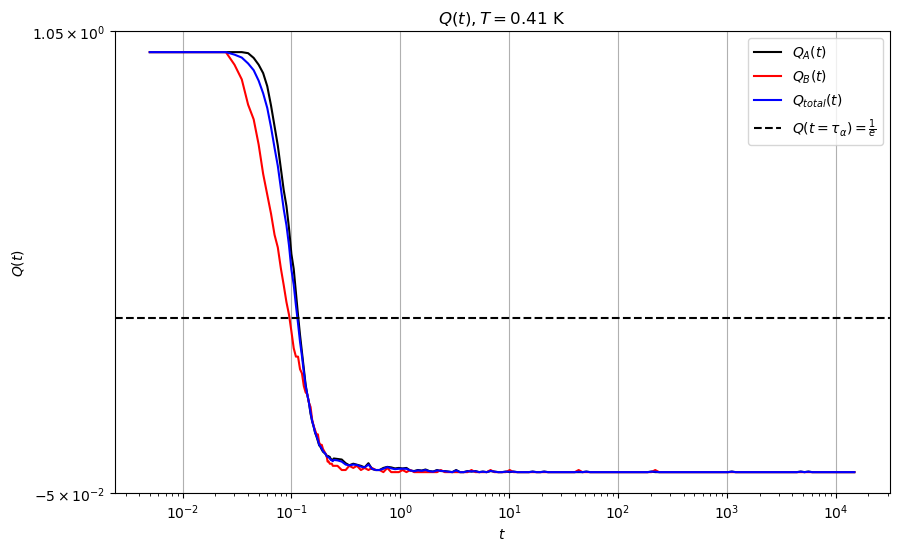

In [38]:
# Computation of Q(t) for particles A and B:
Q_A = calculate_Q(positions_A_lammps, a0)
Q_B = calculate_Q(positions_B_lammps, a0)

# Computation of Q(t) 
Q = calculate_Q(positions_lammps, a0)

# Unidimensional array representing time
#time = np.arange(len(Q_A)) * Deltat

#Q(t) plot
plt.figure(figsize=(10, 6))
plt.loglog(t, Q_A, label=r'$Q_A(t)$', color='black')
plt.loglog(t, Q_B, label=r'$Q_B(t)$', color='red')
plt.loglog(t, Q, label=r'$Q_{total}(t)$', color='blue')
plt.xlabel('$t$')
plt.ylabel(f'$Q(t)$')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise
plt.title(f'$Q(t), T = {temperature}$ K')

# Karmakar paper [3]: 'The α-relaxation time, τα is defined at the time where this correlation function decays 
# to 1/e to its initial value as Q(t = τα) = 1/e '
plt.axhline(y=1/np.e, color='black', linestyle='--', label=r'$Q(t=\tau_{\alpha}) = \frac{1}{e}$')
plt.legend()


plt.grid(True)
plt.show()

In [45]:
# For Q(t) function:
tau_alpha = find_tau_alpha(Q)
print(f"τ_α for the system is at time step {tau_alpha}")
# Corresponding time value (tau_alpha is the time step):
tau_alpha_time = t[tau_alpha]  
print(f"t = τ_α = {tau_alpha_time}")

τ_α for the system is at time step 22
t = τ_α = 0.115


In [39]:
def calculate_chi_4(positions, a0):
    n_particles = positions.shape[1]
    n_steps     = positions.shape[0]
    
    Q_i = np.zeros((n_steps, n_particles), dtype=np.float64)
    
    # Computation of Q_i(t) for each atom:
    for t in range(n_steps):
        for i in range(n_particles):
            distance = np.linalg.norm(positions[t, i] - positions[0, i])
            w = 1 if distance <= a0 else 0
            Q_i[t, i] = w
    
    # Computation of <Q(t)> and <Q(t)^2>
    Q_mean = np.mean(Q_i, axis=1)
    Q_mean_sq = np.mean(Q_i**2, axis=1)
    
    # Computation of chi_4(t)
    chi_4 = (Q_mean_sq - Q_mean**2) / n_particles
    
    return chi_4

In [40]:
# Calculate chi_4(t) for both atom types
chi_4_A = calculate_chi_4(positions_A_lammps, a0)
chi_4_B = calculate_chi_4(positions_B_lammps, a0)
# And total:
chi_4   = calculate_chi_4(positions_lammps, a0)

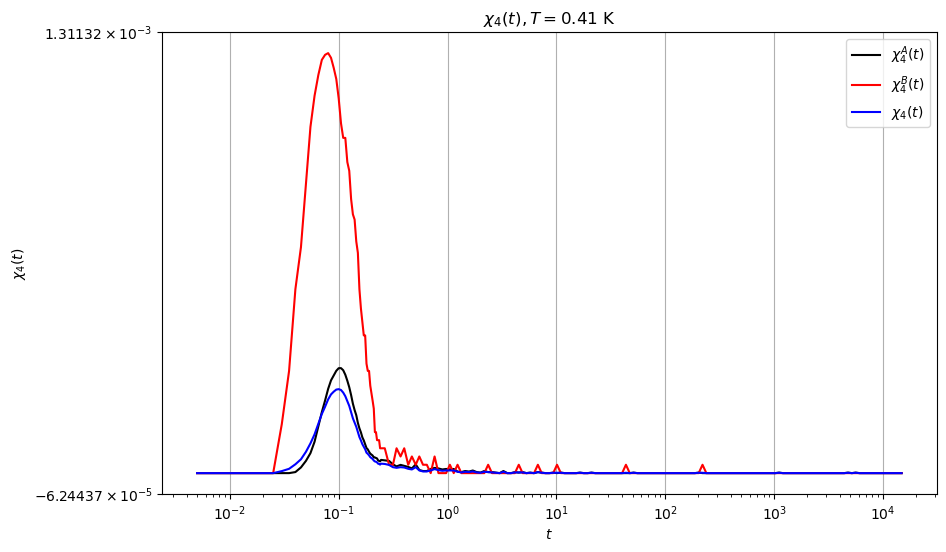

In [43]:
# Plotting chi_4(t)
plt.figure(figsize=(10, 6))
plt.loglog(t, chi_4_A, label=r'$\chi_4^{A}(t)$', color='black')
plt.loglog(t, chi_4_B, label=r'$\chi_4^{B}(t)$', color='red')
plt.loglog(t, chi_4, label=r'$\chi_4(t)$', color='blue')

plt.xlabel('$t$')
plt.ylabel(r'$\chi_4(t)$')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise

plt.title(f'$\chi_4(t), T = {temperature}$ K')
plt.legend()
plt.grid(True)
plt.show()

chi_4 maximum value is 0.000249676 at time 0.1.
τ_4 = 0.1
τ_α = 0.115


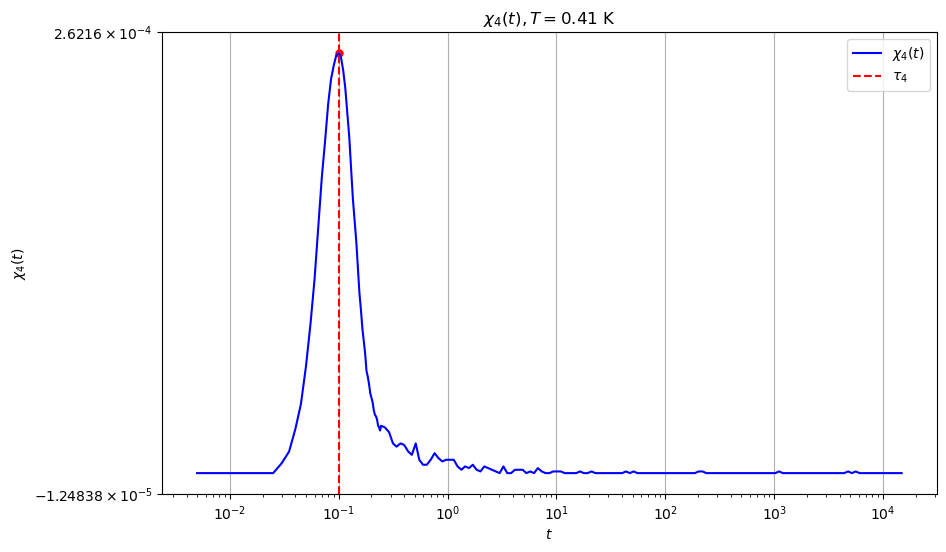

In [48]:
def find_max_chi_4(chi_4):

#Find the maximum value of chi_4 and the corresponding index.
    max_value = np.max(chi_4)
    max_index = np.argmax(chi_4)
    
    return max_value, max_index

max_value, max_index = find_max_chi_4(chi_4)

# Corresponding time value (max_index is the time step):
tau_4 = t[max_index]

print(f"chi_4 maximum value is {max_value} at time {tau_4}.")
print(f"τ_4 = {tau_4}")
print(f"τ_α = {tau_alpha_time}")

# Plotting chi_4(t) with t_4 highlighted:
plt.figure(figsize=(10, 6))
plt.loglog(t, chi_4, label=r'$\chi_4(t)$', color='blue')

plt.xlabel('$t$')
plt.ylabel(r'$\chi_4(t)$')
plt.title(f'$\chi_4(t), T = {temperature}$ K')
plt.axvline(x=tau_4, color='red', linestyle='--', label=r'$\tau_4$ ')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise

# Marker:
plt.scatter(tau_4, max_value, color='red', s=25, marker='o')
plt.legend()
plt.grid(True)
plt.show()

## $\beta$-relaxation regime

C:\Users\emanu\AppData\Local\Temp\ipykernel_23464\719145579.py:2: RuntimeWarning: divide by zero encountered in log
  log_msd_lammps_A = np.log(msd_A)
C:\Users\emanu\AppData\Local\Temp\ipykernel_23464\719145579.py:3: RuntimeWarning: divide by zero encountered in log
  log_msd_lammps_B = np.log(msd_B)


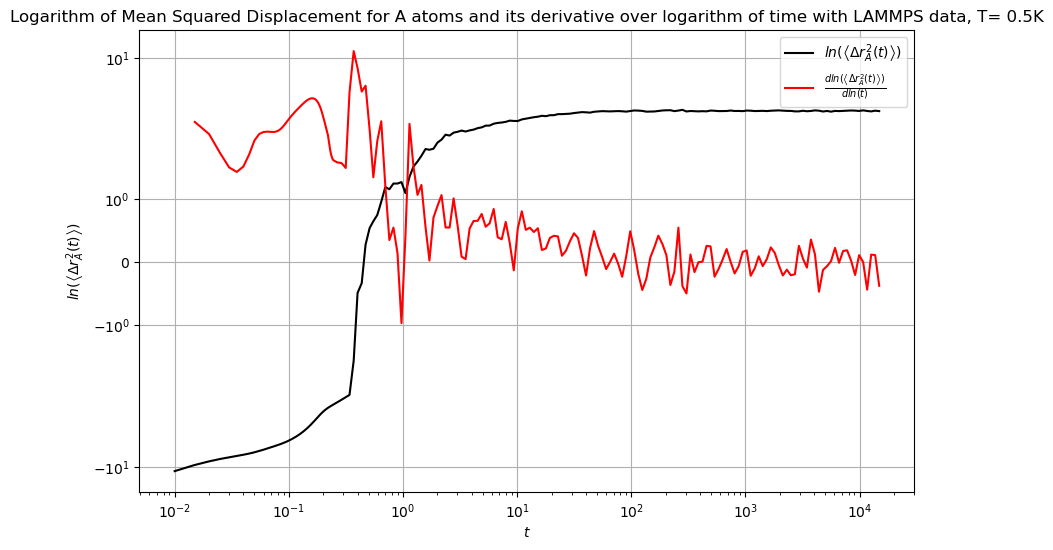

In [49]:
# Compute the logarithm of MSD: 
log_msd_lammps_A = np.log(msd_A)
log_msd_lammps_B = np.log(msd_B)

# Compute derivative of ln(<r^2>) wrt ln(t):
log_t = np.log(t)
dlogMSD_dlogt_A = np.gradient(log_msd_lammps_A, log_t)
dlogMSD_dlogt_B = np.gradient(log_msd_lammps_B, log_t)

# Results Visualization:
plt.figure(figsize=(10, 6))
# Plotting ln(<r_A^2>) over time:
plt.loglog(t, log_msd_lammps_A, color='black', label=r'$ ln (\left \langle \Delta r_{A}^2 (t) \right \rangle)$')
plt.loglog(t, dlogMSD_dlogt_A, color='red', label=r'$ \frac{dln (\left \langle \Delta r_{A}^2 (t) \right \rangle)}{dln(t)}$')
plt.xlabel('$t$')
plt.ylabel(r'$ ln (\left \langle \Delta r_{A}^2 (t) \right \rangle)$')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise
plt.title('Logarithm of Mean Squared Displacement for A atoms and its derivative over logarithm of time with LAMMPS data, T= 0.5K')
plt.grid(True)
plt.legend()
plt.show()

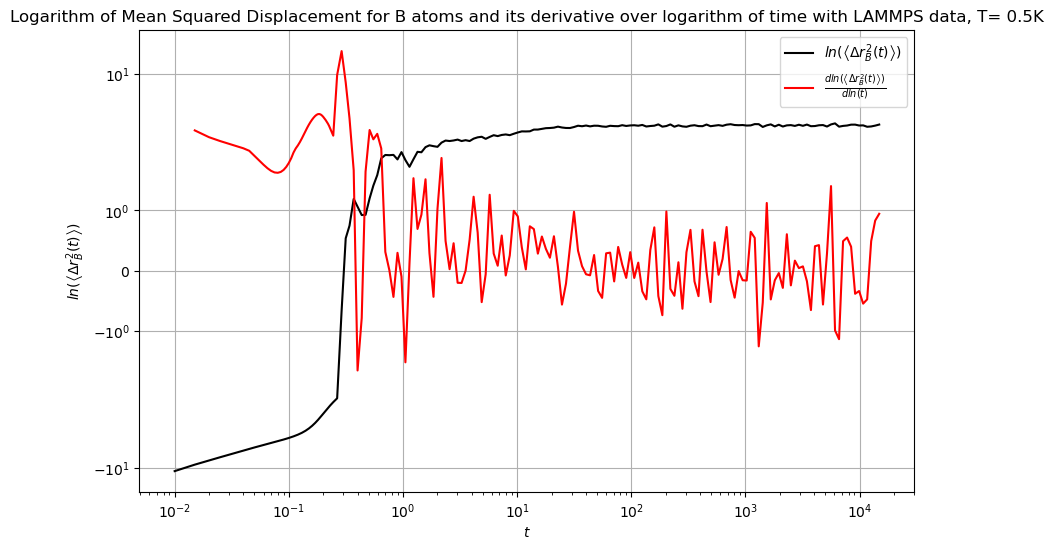

In [50]:
# Plotting ln(<r_B^2>) over time:
plt.figure(figsize=(10, 6))
plt.loglog(t, log_msd_lammps_B, color='black', label=r'$ ln (\left \langle \Delta r_{B}^2 (t) \right \rangle)$')
plt.loglog(t, dlogMSD_dlogt_B, color='red', label=r'$ \frac{dln (\left \langle \Delta r_{B}^2 (t) \right \rangle)}{dln(t)}$')
plt.xlabel('$t$')
plt.ylabel(r'$ ln (\left \langle \Delta r_{B}^2 (t) \right \rangle)$')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise
plt.title('Logarithm of Mean Squared Displacement for B atoms and its derivative over logarithm of time with LAMMPS data, T= 0.5K')
plt.grid(True)
plt.legend()
plt.show()

In [51]:
# Function to find tau_beta:
def find_tau_beta(t, dlog_msd_dlog_t):
    
    # Identify the minimum in the derivative (the dip)
    tau_beta_idx = np.argmin(dlog_msd_dlog_t)
    tau_beta = t[tau_beta_idx]
    
    return tau_beta

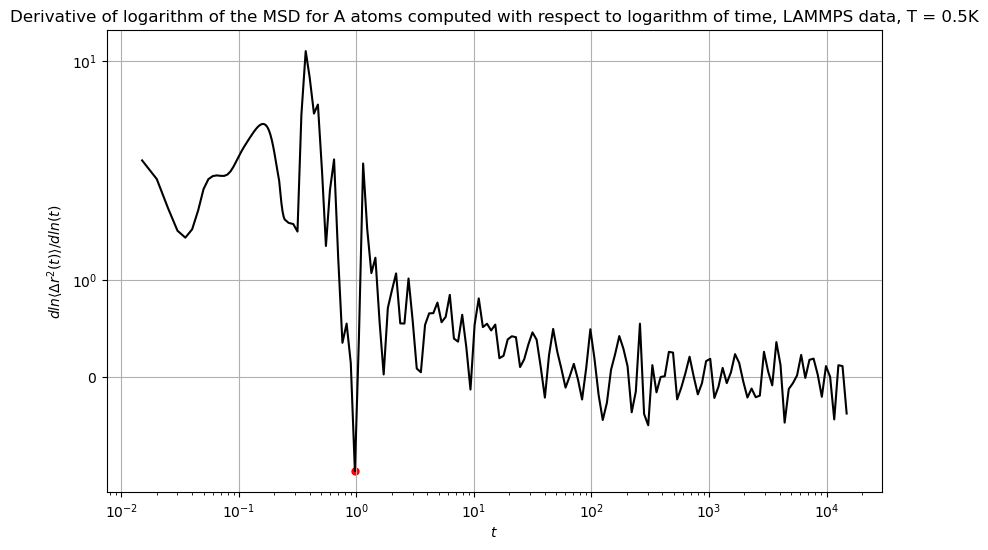

τ_β_A = 0.97


In [52]:
# Detection of tau_beta for A atoms:
tau_beta_A = find_tau_beta(t, dlogMSD_dlogt_A)
# Find the index corresponding to tau_beta_A in the array t
tau_beta_A_index = np.argmin(np.abs(t - tau_beta_A))
# Get the value of the derivative at tau_beta_A
tau_beta_A_value = dlogMSD_dlogt_A[tau_beta_A_index]

# Plotting dln<r^2>/dlnt over time:
plt.figure(figsize=(10, 6))
plt.loglog(t, dlogMSD_dlogt_A, color='black')
plt.xlabel('$t$')
plt.ylabel(r'$ dln\left \langle \Delta r^2 (t) \right \rangle/dln(t)$')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise
# Marker on plot:
plt.scatter(tau_beta_A, tau_beta_A_value, color='red', s=25, marker='o')
plt.grid(True)
#plt.legend()
plt.title('Derivative of logarithm of the MSD for A atoms computed with respect to logarithm of time, LAMMPS data, T = 0.5K')
plt.show()

# Output dei risultati:
print(f"τ_β_A = {tau_beta_A}")

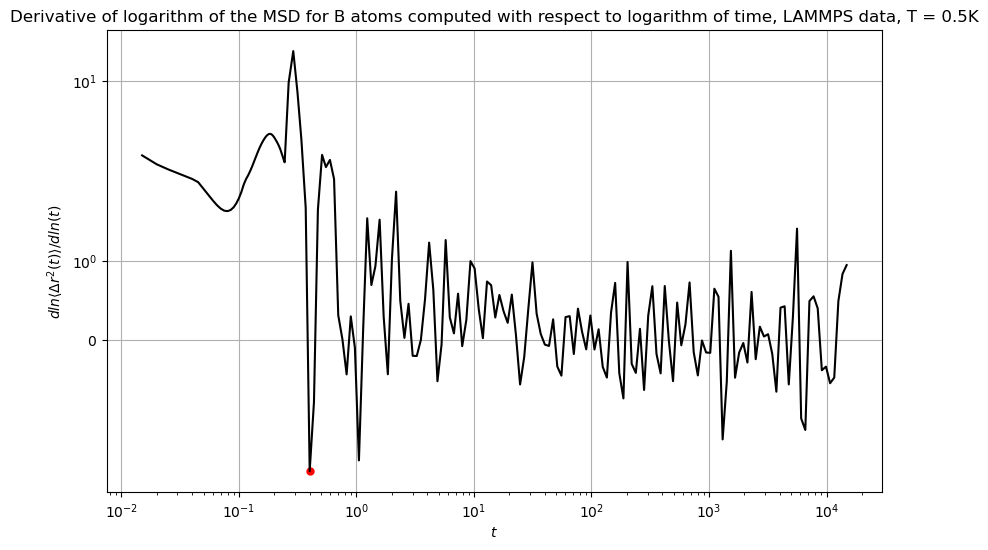

τ_β_B = 0.4


In [53]:
# Detection of tau_beta for B atoms:
tau_beta_B = find_tau_beta(t, dlogMSD_dlogt_B)
# Find the index corresponding to tau_beta_B in the array t
tau_beta_B_index = np.argmin(np.abs(t - tau_beta_B))
# Get the value of the derivative at tau_beta_A
tau_beta_B_value = dlogMSD_dlogt_B[tau_beta_B_index]

# Plotting dln<r^2>/dlnt over time:
plt.figure(figsize=(10, 6))
plt.loglog(t, dlogMSD_dlogt_B, color='black')
plt.xlabel('$t$')
plt.ylabel(r'$ dln\left \langle \Delta r^2 (t) \right \rangle/dln(t)$')
plt.yscale('symlog')  # symmetric logarithmic y-axis --> useful for negative values and strong presence of noise
# Marker on plot:
plt.scatter(tau_beta_B, tau_beta_B_value, color='red', s=25, marker='o')
plt.grid(True)
#plt.legend()
plt.title('Derivative of logarithm of the MSD for B atoms computed with respect to logarithm of time, LAMMPS data, T = 0.5K')
plt.show()

# Output dei risultati:
print(f"τ_β_B = {tau_beta_B}")

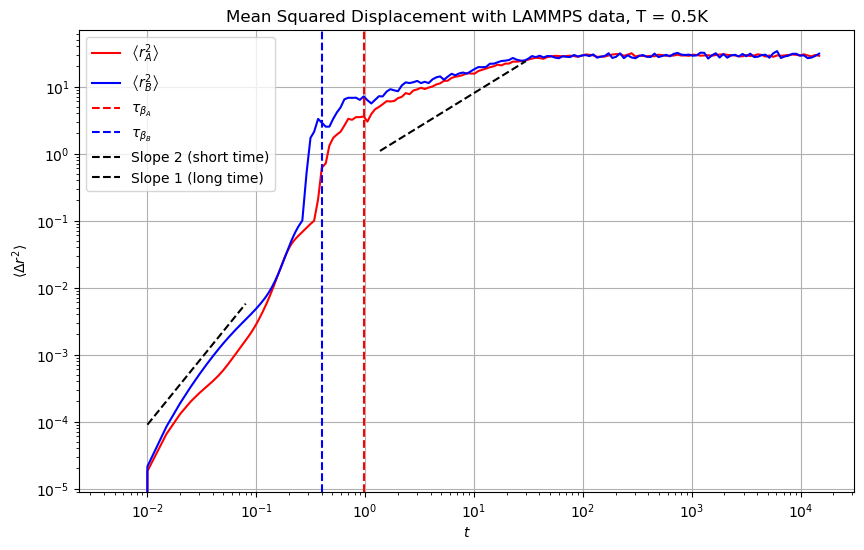

τ_β_A = 0.97
τ_β_B = 0.4


In [66]:
# Logarithmic plot:
plt.figure(figsize=(10, 6))
plt.loglog(t, msd_A, color='red', label=r'$\left\langle r_{A}^2 \right\rangle$')
plt.loglog(t, msd_B, color='blue', label=r'$\left\langle r_{B}^2 \right\rangle$')
#plt.plot(t, Q, label=r'$Q_{total}(t)$', color='blue')
plt.xlabel('$t$')
plt.ylabel(r'$\left \langle \Delta r^2 \right \rangle$')
plt.title(f'Mean Squared Displacement with LAMMPS data, T = 0.5K')
plt.axvline(x=tau_beta_A, color='red', linestyle='--', label=r'$\tau_{\beta_{A}}$')
plt.axvline(x=tau_beta_B, color='blue', linestyle='--', label=r'$\tau_{\beta_{B}}$')

# Adding the dashed lines:
# Line with slope 2
t_short = np.linspace(0.01, 0.08, 80)
plt.loglog(t_short, 0.9 * t_short**2, '--', label='Slope 2 (short time)', color='black')

# Line with slope 1
t_long = np.linspace(tau_beta_A+0.4, 30, 80)
plt.loglog(t_long, 0.8 * t_long, '--', label='Slope 1 (long time)', color='black')

plt.legend()
plt.grid(True)
plt.show()

### Print characteristics time of beta relaxation:
print(f"τ_β_A = {tau_beta_A}")
print(f"τ_β_B = {tau_beta_B}")

In [68]:
# Alpha times for A and B atoms:
tau_alpha_value = 1/np.e

tau_alpha_lammps_A = find_tau_alpha(Q_A)
print(f"τ_α for the type A atoms is at time step {tau_alpha_lammps_A}")

# Corresponding time value (tau_alpha is the time step):
tau_alpha_time_lammps_A = t[tau_alpha_lammps_A]  
print(f"t = τ_α_A = {tau_alpha_time_lammps_A}")

tau_alpha_lammps_B = find_tau_alpha(Q_B)
print(f"τ_α for the type B atoms is at time step {tau_alpha_lammps_B}")

# Corresponding time value (tau_alpha is the time step):
tau_alpha_time_lammps_B = t[tau_alpha_lammps_B]  
print(f"t = τ_α_B = {tau_alpha_time_lammps_B}")

τ_α for the type A atoms is at time step 22
t = τ_α_A = 0.115
τ_α for the type B atoms is at time step 18
t = τ_α_B = 0.095


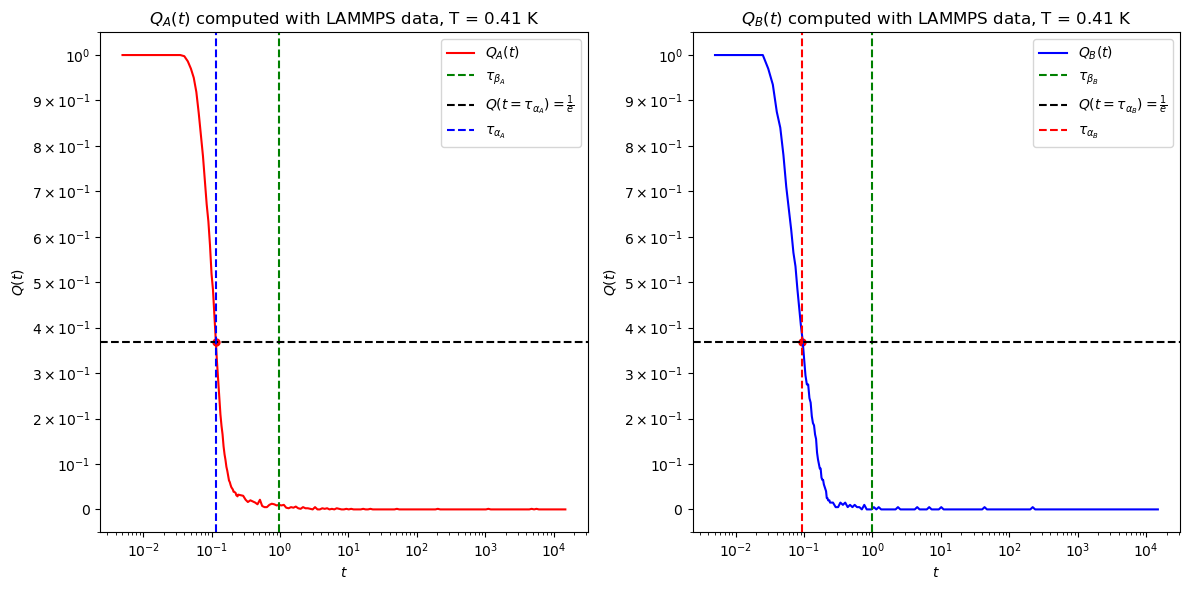

In [72]:
# Results Visualization:
plt.figure(figsize=(12, 6))

# Plot per Q_A
plt.subplot(1, 2, 1)
plt.loglog(t, Q_A, label=r'$Q_A(t)$', color='red')
plt.xlabel('$t$')
plt.ylabel(f'$Q(t)$')
plt.title(f'$Q_A(t)$ computed with LAMMPS data, T = 0.41 K')
# Add ticks for a better comparison with Karmakar paper
plt.yscale('symlog')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.axvline(x=tau_beta_A, color='green', linestyle='--', label=r'$\tau_{\beta_{A}}$')
# Karmakar paper [3]: 'The α-relaxation time, τα is defined at the time where this correlation function decays 
# to 1/e to its initial value as Q(t = τα) = 1/e '
plt.axhline(y=1/np.e, color='black', linestyle='--', label=r'$Q(t=\tau_{\alpha_{A}}) = \frac{1}{e}$')
plt.axvline(x=tau_alpha_time_lammps_A, color='blue', linestyle='--', label=r'$\tau_{\alpha_{A}}$')
# Marker:
plt.scatter(tau_alpha_time_lammps_A, tau_alpha_value, color='red', s=25, marker='o')
plt.legend()
#plt.grid(True)




# Plot per Q_B
plt.subplot(1, 2, 2)
plt.loglog(t, Q_B, label=r'$Q_B(t)$', color='blue')
plt.xlabel('$t$')
plt.ylabel(f'$Q(t)$')
plt.title(f'$Q_B(t)$ computed with LAMMPS data, T = 0.41 K')
# Add ticks for a better comparison with Karmakar paper
plt.yscale('symlog')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.axvline(x=tau_beta_A, color='green', linestyle='--', label=r'$\tau_{\beta_{B}}$')
# Karmakar paper [3]: 'The α-relaxation time, τα is defined at the time where this correlation function decays 
# to 1/e to its initial value as Q(t = τα) = 1/e '
plt.axhline(y=1/np.e, color='black', linestyle='--', label=r'$Q(t=\tau_{\alpha_{B}}) = \frac{1}{e}$')
plt.axvline(x=tau_alpha_time_lammps_B, color='red', linestyle='--', label=r'$\tau_{\alpha_{B}}$')
# Marker:
plt.scatter(tau_alpha_time_lammps_B, tau_alpha_value, color='red', s=25, marker='o')
plt.legend()
#plt.grid(True)

plt.tight_layout()
plt.show()